# Demo  on TurboGP Trees Scores

## 1. Intro

First, the libraries required to use TurboGP. In general, you will want to use numpy (to process training and testing datasets), matplotlib (to plot fitness and diversity evolution), and networkx (in complement with matplotlib, to graphically visualize GP trees, i.e. generated models)

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import tqdm

from six.moves import cPickle as pickle
from networkx.drawing.nx_agraph import graphviz_layout
from GPIndividuals import *      # where core classes (node, tree) are defined
from GPOperators import *        # where basic crossover and mutation are defined
from GPflavors import *          # where population dynamics (such as steady-state) are defined

from LowLevel import *           # where low-level primitives are defined
from Mezzanine import *          # where mezzanine-level primitives are defined
from HighLevel import *          # where high-level primitives are defined
from Trimmers import *           # where 'trimmers' are defined

from GPUtils import *            # Selection (binary tournament, roulette wheel, elite selection) and migration methods
from Utils import *              # other optional functions

import warnings
warnings.simplefilter('ignore')

## 2. Create a GP Tree with Low Level operations

In [2]:
# Each of these functions must be properly defined in the corresponding python modules.
lowlevel = ['ADD', 'SUB', 'MUL', 'DIV', 'RELU', 'SIGM', 'X2', 'X3', 'MAX', 'MEAN', 'MIN']
mezzanine = None
highlevel = None

# Now we let the Node objects know the set of input based primitives available at each layer.
Node.f1_set=lowlevel
Node.f2_set=mezzanine
Node.f3_set=highlevel

In [3]:
# Each of these trimmer functions also need to be defined in the corresponding python module.
trimmers = ['TFull']

#Node.i1_set=[0,10]              # i1 set (feature variables) is defined for each tree created
Node.i2_set=[-1.0,1.0]           # scalar constant terminals range (-1.0 to 1.0 in this example)
Node.i3_set = trimmers           # Trimmers

Node.i4_set=[]                   # set of constant vector or array-like terminal nodes (masks, prototypes, etc.)    
for _ in range(4):
    # For this set of examples we will simply create a few random 3x3 arrays.
    Node.i4_set.append(np.random.uniform(low=-.1, high=.1, size=(3,3)))

# uncomment to visualize generated constants array
#Node.i4_set

Now we can create a GP tree that will rely only on low-level primitives. When creating a tree there are two steps:
    1. allocating the variable for the object tree
    2. actually generating (growing) a random tree

In [4]:
# Create a new object of the class tree, specifiying the max allowed depth, and the set of input feature variables:
tree1 = Tree(max_tree_depth=7, i1_set=np.arange(49))
# Generate the tree
tree1.grow_random_tree()

Now that we have generated a tree, we can list its nodes simply by:

In [5]:
tree1.nodes

[(0, ADD, [1, 2]),
 (1, 14, []),
 (2, X3, [3]),
 (3, SIGM, [4]),
 (4, MUL, [5, 6]),
 (5, ADD, [7, 8]),
 (6, 35, []),
 (7, SIGM, [9]),
 (8, 44, []),
 (9, -0.928765793632947, [])]

However, it is more interesting and easier to visualize it graphically. We need to create a graph object from the tree and then using networkx/graphviz libraries (along matplotlib) to display it:

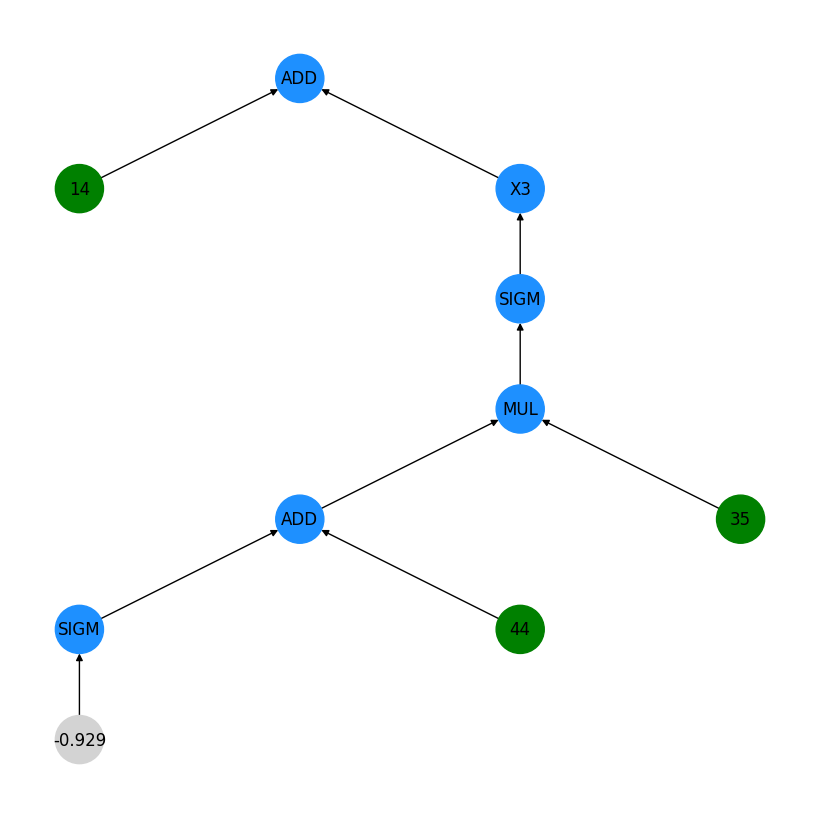

In [6]:
plt.figure(figsize=(8,8))
graph, labels, color_map = get_graph(tree1)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=1200, node_color=color_map)

Checking GP tree depth:

In [7]:
tree1.get_tree_depth()

6

Checking GP tree branching factor:

In [8]:
tree1.get_tree_bf()

2

Checking tree morphology score, which is calculated with:
$$
S = \frac{tree\_depth \cdot tree\_bf}{10} 
$$


In [9]:
tree1.get_score()

1.2

## Score x population evolution

Using a the same example as 02 notebook, with SimpleRegressor we will analyze how the score evolves as the training phase runs in the GP model.

In [10]:
from Regressor import *

In [11]:
# Training set

# samples
x_training = np.random.rand(1000,1)
x_training = (x_training * 6.28) - 3.14

# labels
y_training = np.sin(x_training).flatten()

Let's see our training samples and labels:

In [12]:
for i in range(len(x_training)):
    print('sin({:.3f}) = {:.3f}'.format(x_training[i][0], y_training[i]))

sin(-2.598) = -0.517
sin(-1.965) = -0.923
sin(0.507) = 0.486
sin(3.104) = 0.038
sin(0.803) = 0.719
sin(-1.887) = -0.950
sin(2.068) = 0.879
sin(0.337) = 0.331
sin(0.466) = 0.449
sin(0.751) = 0.683
sin(-2.649) = -0.473
sin(0.717) = 0.657
sin(-2.435) = -0.649
sin(-0.687) = -0.634
sin(-0.716) = -0.656
sin(0.775) = 0.700
sin(-1.915) = -0.941
sin(-2.446) = -0.641
sin(1.832) = 0.966
sin(-0.789) = -0.710
sin(-1.987) = -0.915
sin(0.702) = 0.646
sin(-1.113) = -0.897
sin(0.212) = 0.210
sin(-0.551) = -0.524
sin(0.775) = 0.700
sin(0.404) = 0.393
sin(-0.798) = -0.716
sin(1.422) = 0.989
sin(-2.651) = -0.471
sin(-2.305) = -0.742
sin(2.104) = 0.861
sin(2.740) = 0.391
sin(2.459) = 0.631
sin(0.540) = 0.514
sin(-1.545) = -1.000
sin(0.996) = 0.839
sin(1.161) = 0.917
sin(-1.721) = -0.989
sin(2.988) = 0.153
sin(0.740) = 0.674
sin(1.558) = 1.000
sin(1.463) = 0.994
sin(-0.461) = -0.445
sin(-2.006) = -0.907
sin(2.543) = 0.564
sin(-0.068) = -0.068
sin(1.293) = 0.962
sin(1.512) = 0.998
sin(1.043) = 0.864
sin(-1.5

Let's also create a testing dataset, that we will use to measure our models out-of-sample performance (validation). We will generate only 200 points for the testing dataset.

In [13]:
# Testing set

# samples
x_testing = np.random.rand(200,1)
x_testing = (x_testing * 6.28) - 3.14

# labels
y_testing = np.sin(x_testing).flatten()

# Turbo GP setup

Now let's configure some global variables required for TurboGP. These are the standard GP hyperparameters, such as: population size, genetic operations used, etc.

The very first thing we need to setup in TurboGP, is the primitives set. TurboGP supports different types of primitives, but for this example we only need to use standard primitives typically used in any generic GP, such as arithmetic operations, etc. For more details on the different types of primitives supported by TurboGP, refer to notebook 00. 

Here, within the context of TurboGP, standard primitives are called 'Low Level' primitives:

In [14]:
# Each of these functions must be properly defined in the corresponding python modules.
lowlevel = ['ADD', 'SUB', 'MUL', 'DIV', 'X2', 'MAX', 'MEAN', 'MIN', 'RELU']
mezzanine = None
highlevel = None


# Now we let the Node objects know the set of input based primitives available at each layer.
Node.f1_set=lowlevel
Node.f2_set=mezzanine
Node.f3_set=highlevel

# This is the range of constants leaf nodes can take a value from (when not taking the form of a input variable)
Node.i2_set=[-1.0,1.0]

We included in our set of GP primitives binary arithmetic operations $[+, -, \times, \div]$, square $x^2$, the max of two numbers, the mean of two numbers, the minimum of two numbers, and the rectifier, which is defined as $max(0,x)$.

Notice how we did not employ sine or cosine functions. Sine and other trigonometric functions are typical primitives in GP. However, we do not want GP to find "the answer we already knew" to the problem, but rather we want GP to find a way (learn) to approximate a sine function with only arithmetic operations and few other simple computational functions as commodities (imagine we are trying to find how to implement trigonometric functions in a very small CPU without hardware implementations).

Now we will specify the rest of the hyperparameters needed for a GP run:

In [15]:
pop_size = 1000                                  # Population size

oper = [SimpleRegresor.mutation,                 # Genetic operations to use.
        SimpleRegresor.protected_crossover]      # notice how they are defined by the type of individual we will evolve

oper_prob = [.5, .5]                             # Probabity of each GP operation (in the same order as declared above)
oper_arity = [1, 2]                              # How many parents required by each operation.

l_rate = 1.0                                     # Offspring pool size, defined as the ratio to the population size.

minimization = True                              # if it is a minimization problem or not
sel_mechanism = binary_tournament                # Preferred selection mechanism for parent selection

# Creation of the initial population

In [16]:
%%time
Population = []

for _ in range(pop_size):
    Population.append(SimpleRegresor(input_vector_size=1,
                                   complexity = 7))

CPU times: user 1.58 s, sys: 17 ms, total: 1.59 s
Wall time: 1.62 s


# Evolutionary cycle

100%|██████████| 10/10 [06:00<00:00, 36.02s/it]


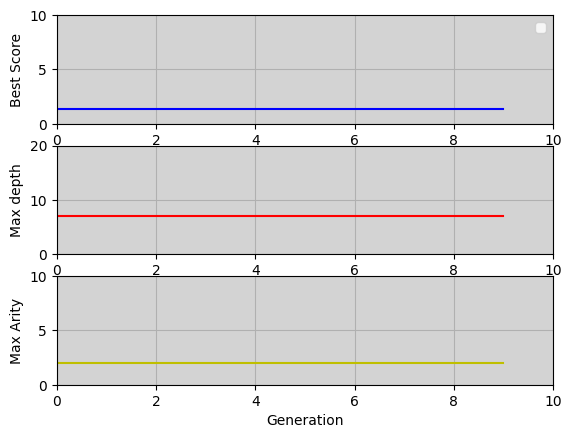

In [20]:
Generations = 10                        

diversity = []
fitness = []
test_fitness = []
best_score = []
max_depth = []
max_arity = []


############################################################################################################
# The following piece of code, will allow us to display -in real time- the progress of training fitness,   #
# testing fitness and diversity decay. It is a bit overcomplicated, and it is optional of course, but it   #
# is very useful to understand and visualize if the GP is achieving convergence.                           #

x = list(range(Generations))                                                                               #

y = np.empty(Generations)                                                                                  #
y[:]=np.nan                                                                                                #
y2 = np.empty(Generations)                                                                                 #
y2[:]=np.nan                                                                                               #
y3 = np.empty(Generations)                                                                                 #
y3[:]=np.nan                                                                                               #

plt.ion()                                                                                                  #

fig = plt.figure()                                                                                         #
ax = fig.add_subplot(311)                                                                                  # 
ax.set_ylabel('Best Score')                                                                              #
ax.set_ylim(0.0,10.0)                                                                                       #
ax.set_xlim(0,Generations)                                                                                 #
ax.set_facecolor('lightgray')                                                                              #  
ax.grid(True)                                                                                              #

ax2 = fig.add_subplot(312)                                                                                 #
ax2.set_xlabel('Generation')                                                                               #
ax2.set_ylabel('Max depth')                                                                                #
ax2.set_ylim(0.0,20.0)                                                                                      #
ax2.set_xlim(0,Generations)                                                                                #
ax2.set_facecolor('lightgray')                                                                             #
ax2.grid(True)     

ax3 = fig.add_subplot(313)                                                                                 #
ax3.set_xlabel('Generation')                                                                               #
ax3.set_ylabel('Max Arity')                                                                                #
ax3.set_ylim(0.0,10.0)                                                                                      #
ax3.set_xlim(0,Generations)                                                                                #
ax3.set_facecolor('lightgray')                                                                             #
ax3.grid(True)                                                                                             #
                                                                                        #

line1, = ax.plot(x, y, 'b-')                                                             #
line2, = ax2.plot(x, y2, 'r-')                                                             #
line3, = ax3.plot(x, y3, 'y-')                                                                             #
ax.legend()                                                                                                #
############################################################################################################

pbar = tqdm.tqdm(total=Generations)                         # We can also use tqdm to display a progress bar


for i in range(Generations):
        
    Population, d, bf, tf = Steady_State(Population = Population,
                                         batch = x_training,
                                         labels = y_training,
                                         test_batch = x_testing,
                                         test_labels = y_testing,
                                         l_rate = l_rate,
                                         oper = oper,
                                         oper_prob = oper_prob,
                                         oper_arity = oper_arity,
                                         minimization = minimization,
                                         sel_mechanism = sel_mechanism,
                                         online = False)
    
    depth = get_max_population_depth(Population)
    arity = get_max_population_bf(Population)
    score = get_max_population_score(Population)

    max_arity.append(arity)
    max_depth.append(depth)
    best_score.append(score)


        
    
    # For live plotting #################
    y[i]=best_score[i]
    y2[i]=max_depth[i]
    y3[i]=max_arity[i]
    
    line1.set_ydata(y)
    line2.set_ydata(y2)
    line3.set_ydata(y3)
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    #####################################
    
    pbar.update(1)      
    
pbar.close()